## Schur-Parlett Algorithm Implementation

The cell below is my implementation of the Schur-Parlett algorithm without reordering, which works for any square matrix of size n x n. It compares the output of the algorithm to the direct function calculation using **scipy** expm. The norm of the difference between the Schur-Parlett output and the scipy calculation should be around floating point accuracy (1e-16), but as the size of the matrix increases, so does the error. 

Made by Ali Hindy

In [377]:
import numpy as np
from scipy.linalg import schur, solve_sylvester, expm

# Schur-Parlett without reordering
def taylorf(f, T, shift):
    """ Computes f(T) using a Taylor series expansion around `shift`. """
    maxiter = 300
    lookahead = 10
    n = T.shape[0]
    tay = np.poly1d(f(shift + np.polynomial.Taylor(np.eye(n), domain=[-1, 1])))
    M = T - shift * np.eye(n)
    P = M
    F = tay.coef[0] * np.eye(n)
    for k in range(1, maxiter):
        needorder = k + lookahead
        if needorder > len(tay.coef):
            tay = np.poly1d(f(shift + np.polynomial.Taylor(np.eye(n), domain=[-1, 1], window=[-1, 1])))
        Term = tay.coef[k] * P
        F += Term
        P = P @ M
        if np.linalg.norm(Term, ord=np.inf) < np.finfo(float).eps * np.linalg.norm(F, ord=np.inf):
            return F
    raise ValueError("Taylor series did not converge")

def blockf(f, T, vals):
    """ Computes f(T) where T is an "atomic" block. """
    n = T.shape[0]
    if n == 1:
        return f(T)
    if np.all(np.imag(vals) == 0):
        return taylorf(f, T, np.mean(np.real(vals)))
    if n == 2:
        v1, v2 = vals
        if np.isclose(v1, np.conj(v2)):
            psi1 = f(v1) / (v1 - v2)
            return 2.0 * np.real(psi1 * (T - np.eye(2) * v2))
    return taylorf(f, T, np.mean(vals))

def recf(f, T, vals):
    """ Computes f(T) using the Parlett recurrence. """
    n = T.shape[0]
    if n == 1:
        return blockf(f, T, vals)
    
    F = np.zeros_like(T)
    for j in range(n):
        for i in range(j, -1, -1):
            if i == j:
                F[i, j] = f(T[i, j])
            else:
                RHS = F[i, i] * T[i, j] - T[i, j] * F[j, j]
                for k in range(i + 1, j):
                    RHS += T[i, k] * F[k, j]
                F[i, j] = RHS / (T[i, i] - T[j, j])
    return F

def schurparlett(f, A):
    """ Computes f(A) using the Schur-Parlett algorithm. """
    T, Q = schur(A)
    vals = T
    F = recf(f, T, vals)
    return Q @ F @ Q.T
# Example usage:
if __name__ == "__main__":
    # Define your  A
    # A = np.array([[5, 4, 2, 1], [0, 1, -1, -1], [-1, -1, 3, 0], [1, 1, -1, 2]])
    # A = np.array([[3,2,1],[0,2,0], [0,0,1]])
    A = np.array([[3,2],[0,1]])

    # Define the function f, for example f(x) = exp(x)
    f = np.exp
    
    # Compute f(A) using Schur-Parlett algorithm
    result = schurparlett(f, A)
    print("f(A) =\n", result)

    f_true = expm(A)
    print("f(A) true =\n",f_true)
    diff_norm = np.linalg.norm(result - f_true)
    print("\nComparison:")
    print("Norm of difference (F_schur - F_direct):", diff_norm)


f(A) =
 [[20.0855 17.3673]
 [ 0.      2.7183]]
f(A) true =
 [[20.0855 17.3673]
 [ 0.      2.7183]]

Comparison:
Norm of difference (F_schur - F_direct): 4.440892098500626e-16


## Jordan Canonical Form

The cell below uses the Jordan Canonical Form of a matrix to calculate f(A), as described in the paper. This method is slow for larger matrices, as it uses the symbolic representation of the matrix and function to calculate the JCF of the matrix. This method works for any square matrix of size n x n with complex input. The error should be around floating point accuracy (1e-16), but as described in the paper this method breaks down if you apply small perturbations to the matrix. 

In [372]:
from scipy.linalg import schur, solve_sylvester, norm, expm
import sympy as sp
import math 

def apply_functions_to_upper_triangular(J, f):
    n = J.shape[0]
    result = np.zeros_like(J, dtype=np.complex128)  # Initialize result matrix
    for i in range(n):
        result[i, i] = f.subs(x, complex(J[i, i])).evalf()  # Apply f(a_{ii}) to diagonal elements
        f_temp = f 
        if i+1 < n and J[i+1, i+1] == J[i, i]:
            for j in range(i + 1, n):
                k = j - i
                f_derivative = sp.diff(f_temp, x)
                result[i, j] = (f_derivative.subs(x, complex(J[i, i])) / math.factorial(k)).evalf()  # Apply f^(k)(a_{i,j}) / k! to off-diagonal elements
                f_temp = f_derivative 
    return result
    
def funm_jordan(A, fun):
    m = Matrix(A)
    P, J = m.jordan_form()
    P_inv = P.inv()
    
    J_f = apply_functions_to_upper_triangular(J, fun)
    F = (P @ J_f @ P_inv).evalf()
    return F, P, J, P_inv

# Example usage:
# A = np.array([[5, 4, 2, 1], [0, 1, -1, -1], [-1, -1, 3, 0], [1, 1, -1, 2]])
A = np.random.randint(-3, 3, size=(3, 3))
# A = np.array([[-1,2],[0,1]])
print("Matrix A (original):\n",A)

# f = lambda z: z ** 2  # Example function f(z) = z^2
# f = lambda z:  sp.exp(z)
x = sp.symbols('x')

f = sp.exp(x)
F_direct = expm(A)
# f = x**2
# F_direct = A @ A
# Compute f(A) using Jordan normal form
F_jordan, P, J, P_inv = funm_jordan(A, f)

print("Matrix A (reconstructed):\n", np.array((P @ J @ P_inv).evalf()))
print("--------------------------------------------------------------------------------")
print("Matrix F (computed using Jordan normal form):\n",np.array( F_jordan))
# Compute f(A) directly


print("Matrix F (computed directly):\n", F_direct)

# Compare results
diff_norm_jnf = (np.sum(F_jordan - F_direct)**2)**(1/2)
print("\nComparison:")
print("Norm of difference (F_jordan - F_direct):", diff_norm_jnf)


Matrix A (original):
 [[ 1 -1 -1]
 [-2 -2  2]
 [-2  1  2]]
Matrix A (reconstructed):
 [[1.00000000000000 -1.00000000000000 -1.00000000000000]
 [-2.00000000000000 -2.00000000000000 2.00000000000000]
 [-2.00000000000000 1.00000000000000 2.00000000000000]]
--------------------------------------------------------------------------------
Matrix F (computed using Jordan normal form):
 [[13.7684904796726 -4.70313192997444 -12.7684904796726]
 [-12.6324072798282 4.49830981956823 12.6324072798282]
 [-22.3108375394660 7.92927534985372 23.3108375394660]]
Matrix F (computed directly):
 [[ 13.7685  -4.7031 -12.7685]
 [-12.6324   4.4983  12.6324]
 [-22.3108   7.9293  23.3108]]

Comparison:
Norm of difference (F_jordan - F_direct): 1.59872115546023e-14


## Plotting Difference in Accuracy

This method plots the difference in the accuracy between the JCF and the Schur-Parlett algorithm function of matrix approximations. As described in the paper, the Schur-Parlett is numerically stable for small perturbations in matrices, whereas the JCF is not. As you can see in the plot below, the error of the Schur-Parlett algorithm increases by an order of magnitude for a small perturbation of a 2x2 matrix, whereas the the Schur-Parlett algorithm has a small (not statistically significant) increase in error. 

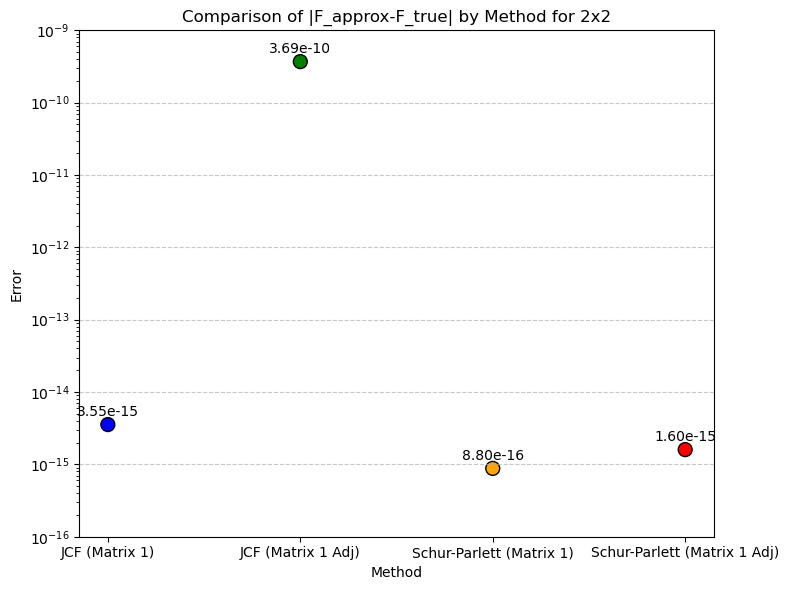

In [376]:
import matplotlib.pyplot as plt

# Define the methods and their corresponding errors
methods = ['JCF (Matrix 1)', 'JCF (Matrix 1 Adj)', 'Schur-Parlett (Matrix 1)', 'Schur-Parlett (Matrix 1 Adj)']
errors = [3.552e-15, 3.694e-10, 8.8e-16, 1.6e-15]

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plotting the points
plt.scatter(methods, errors, color=['blue', 'green', 'orange', 'red'], s=100, edgecolor='black')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Comparison of |F_approx-F_true| by Method for 2x2')
plt.yscale('log')  # Use a logarithmic scale for the y-axis
plt.ylim(1e-16, 1e-9)  # Set y-axis limit from 10^-17 to slightly above the maximum error for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding error values next to each point
for i, v in enumerate(errors):
    plt.text(i, v * 1.2, f'{v:.2e}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [374]:
# Below cells do not fully work: 

In [282]:
import numpy as np
from scipy.linalg import schur, solve_sylvester, norm, expm

# Function to handle Hermitian vs non-Hermitian matrices
def funm(A, f, hermitian=False):
    if hermitian:
        eigenvalues, eigenvectors = np.linalg.eigh(A)
    else:
        eigenvalues, eigenvectors = np.linalg.eig(A)
    
    return eigenvectors @ np.diag(f(eigenvalues)) @ np.linalg.inv(eigenvectors)

# Function to compute a block of the function applied to a matrix
def AtomicBlock(fun, T, tol=np.finfo(float).eps, maxIt=500):
    n = T.shape[0]
    if n == 1:
        return fun(T), 1
    
    σ = np.trace(T) / n
    M = T - σ * np.eye(n)
    Fₛ = fun(σ, 0) * np.eye(n)
    μ = norm(T, np.inf)
    P = M
    max_der = 1
    
    for s in range(1, maxIt + 1):
        inclement = fun(σ, s) * P
        rel_diff = norm(inclement, np.inf) / (tol + norm(Fₛ, np.inf))
        Fₛ += inclement
        P = P @ M / (s + 1)
        
        if rel_diff <= tol * norm(Fₛ, np.inf) / (μ * max_der):
            return Fₛ, s
    
    print("ERROR!")

# Function to block the matrix based on diagonal elements
def blocking(A, delta=0.1):
    a = np.diag(A)
    n = len(a)
    m = np.zeros(n, dtype=int)
    maxM = 0

    for i in range(n):
        if m[i] == 0:
            m[i] = maxM + 1
            maxM += 1
        
        for j in range(i + 1, n):
            if m[i] != m[j]:
                if np.abs(a[i] - a[j]) <= delta:
                    if m[j] == 0:
                        m[j] = m[i]
                    else:
                        p = max(m[i], m[j])
                        q = min(m[i], m[j])
                        if m == p:
                            m[0] = q
                        elif m > p:
                            m[0] -= 1
    
    return m

# Function to reshape the block matrix for further operations
def reshape_M(M):
    len_M = len(M)
    A = np.zeros((len_M, 2), dtype=int)
    for i in range(len_M):
        A[i, :] = M[i]
    return A

# Function to perform swapping of matrix elements
def swapping(m):
    mmax = np.max(m)
    M = []
    ind = []
    h = np.zeros(mmax, dtype=int)
    g = np.zeros(mmax, dtype=int)

    for i in range(1, mmax + 1):
        p = np.where(m == i)[0]
        h[i - 1] = len(p)
        g[i - 1] = np.sum(p) // h[i - 1]

    y = np.sort(g)
    mdone = 0

    for i in y:
        if any(m[mdone:mdone + h[i - 1] - 1] != i):
            f = np.where(m == i)[0]
            g = np.arange(mdone, mdone + h[i - 1])
            ff = np.setdiff1d(f, g)
            gg = np.setdiff1d(g, f)
            v = mdone + np.where(m[mdone:f[-1]] != i)[0]
            M.append(np.concatenate((ff, gg)))
            m[g[-1] + 1:f[-1]] = m[v]
            m[g] = np.full(h[i - 1], i)
            ind.append(np.arange(mdone, mdone + h[i - 1]))
            mdone += h[i - 1]
        else:
            ind.append(np.arange(mdone, mdone + h[i - 1]))

    A = reshape_M(M)
    return A, ind, np.sum(np.abs(np.diff(A)))


def funm_block(A, fun, delta=0.1, tol=np.finfo(float).eps):
    Schur, U = schur(A)
    m = blocking(Schur, delta)
    M, ind, _ = swapping(m)
    
    n = len(A)
    F = np.zeros_like(A)
    
    if np.array_equal(Schur, np.triu(Schur)):
        F = U @ np.diag(fun(np.diag(Schur))) @ U.conj().T
        return F
    
    for col in range(len(ind)):
        j = ind[col]
        F[j, j], _ = AtomicBlock(fun, Schur[j, j], tol)
        
        for row in range(col - 1, -1, -1):
            i = ind[row]
            
            if len(i) == 1 and len(j) == 1:
                k = np.arange(i + 1, j - 1)
                meta = Schur[i, j] * (F[i, i] - F[j, j]) + F[i, k] @ Schur[k, j] - Schur[i, k] @ F[k, j]
                F[i, j] = meta / (Schur[i, i] - Schur[j, j])
            else:
                k = np.concatenate(ind[row + 1:col]) if len(ind[row + 1:col]) > 0 else []
                rhs = F[i, i] * Schur[i, j] - Schur[i, j] * F[j, j] + F[i, k] @ Schur[k, j] - Schur[i, k] @ F[k, j]
                F[i, j] = sylvester(Schur[i, i], -Schur[j, j], rhs)
    
    F = U @ F @ U.conj().T
    return F


# Example usage:
if __name__ == "__main__":
    A = np.array([[5, 4, 2, 1], [0, 1, -1, -1], [-1, -1, 3, 0], [1, 1, -1, 2]])
    # f = lambda z: z**2
    f = lambda z: np.exp(z)  # Example function f(z) = z^2

    F = funm_block(A, f)
    print("Matrix F (computed using Schur-Parlett algorithm):\n", F)

    A_direct = expm(A)
    # A_direct = A @ A
    print("\nMatrix A^2 (computed directly):\n", A_direct)

    diff_norm = np.linalg.norm(F - A_direct)
    print("\nComparison:\nNorm of difference (F - A^2):", diff_norm)


Matrix F (computed using Schur-Parlett algorithm):
 [[ 54.5981   0.      -0.       0.    ]
 [  0.       2.7183   0.      -0.    ]
 [ -0.       0.      30.9936 -23.6045]
 [  0.      -0.     -23.6045  30.9936]]

Matrix A^2 (computed directly):
 [[109.1963 106.478   59.2689   4.6708]
 [ -0.       2.7183  -4.6708  -4.6708]
 [-54.5982 -54.5982   0.       0.    ]
 [ 54.5982  54.5982   7.3891   7.3891]]

Comparison:
Norm of difference (F - A^2): 181.26270500327385
